# Gaussian Mixture Model
this notebook is adapted from python data science handbook

In [1]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style='whitegrid')


## Review of k-Means

C:\Programs\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


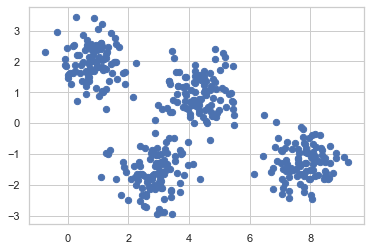

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis');

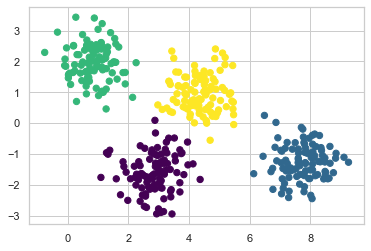

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
kmeans.fit(X) # estimate the centers
labels = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Standard kmeans uses euclidean distance function. <br>
d(x, c) is the distance from a data point x to a center c <br>
Thus, the data points satisfying d(x, c)=r are located on a circle around the center c <br>
The radius of the circle is r = max{d(x, c) for any x in the cluster} - <br>
r is the maximum distance between the center c and the data points in the cluster

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=1, zorder=1))

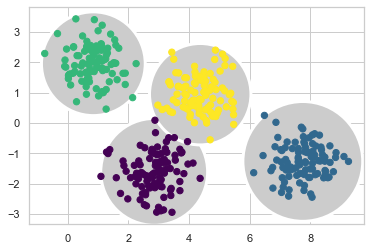

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

The shape of a cluster is a circle

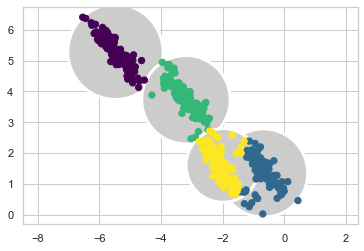

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

In the above figure, the shape of data distribution (`X_stretched`) in each cluster is not a circle.
It is more like a ellipse. <br>
Thus, standard k-means may not work well for ellipse-shaped data distribution.

## Gaussian Mixture Model in 2D

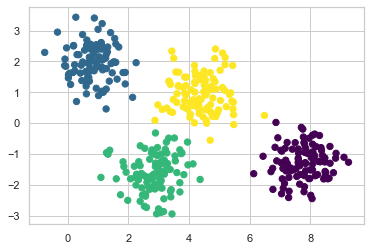

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

r(n,k) is the probability of data point n beloning to cluster/component k <br>
We can obtain the soft assignment matrix [r(n,k)] using gmm.predict_proba

In [8]:
probs = gmm.predict_proba(X)
probs

array([[4.69238090e-01, 1.75162717e-22, 2.76240973e-07, 5.30761633e-01],
       [1.97106146e-17, 4.71110558e-15, 9.99999999e-01, 9.22826700e-10],
       [2.34875746e-14, 3.07981606e-17, 9.99999998e-01, 2.09565089e-09],
       ...,
       [2.32520153e-36, 9.99999933e-01, 2.15904343e-08, 4.50722543e-08],
       [2.87688722e-15, 3.80339560e-04, 4.63399146e-01, 5.36220515e-01],
       [1.10349655e-46, 1.00000000e+00, 6.20815080e-14, 1.19335720e-11]])

We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

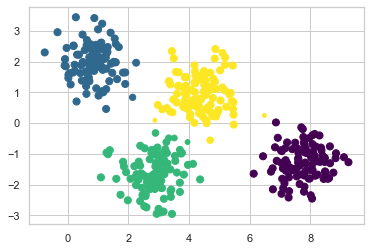

In [9]:
size = 50 * probs.max(axis=1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=0.5)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

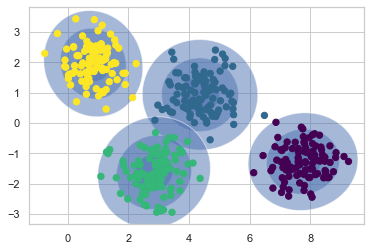

In [11]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

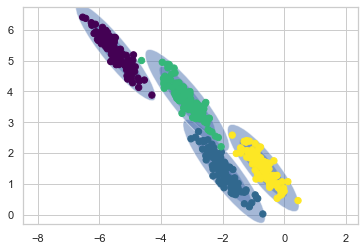

In [12]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.